[Assistants migration guide](https://platform.openai.com/docs/assistants/migration)

# Constants and Libraries

In [1]:
import os
from dotenv import load_dotenv # requires python-dotenv

load_dotenv("./../../config/credentials_my.env")
QUESTION = "Create a visualization of a sinewave"

# Create a client to connecto Azure OpenAI service and deployment

In [2]:
from openai import AzureOpenAI

# Create the client
client = AzureOpenAI(
    # api_key        = os.getenv("AZURE_OPENAI_API_KEY"),  
    # api_version    = os.getenv("AZURE_OPENAI_API_VERSION"), # at least 2024-02-15-preview
    # azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
)
print(f"client.base_url: {client.base_url}")

client.base_url: https://mmoaiswc-01.openai.azure.com/openai/


# Create an Assistant with `code_interpreter`

In [3]:
assistant = client.beta.assistants.create(
    name="Smart Assistant",
    description="You are a helpful AI assistant who helps answering questions",
    tools = [{"type": "code_interpreter"}],
    model = os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME")
)

assistant

Assistant(id='asst_jXRofd83Du9pbpHY4whlsFqP', created_at=1738145601, description='You are a helpful AI assistant who helps answering questions', instructions=None, metadata={}, model='gpt-4o', name='Smart Assistant', object='assistant', tools=[CodeInterpreterTool(type='code_interpreter')], response_format='auto', temperature=1.0, tool_resources=ToolResources(code_interpreter=ToolResourcesCodeInterpreter(file_ids=[]), file_search=None), top_p=1.0)

# Create a conversation
Note that `code_interpreter` and `file_search` are empty in this case, because `code_interpreter` was not created.

In [4]:
# Create a thread
thread = client.beta.threads.create()
print(thread)

Thread(id='thread_YrvMssUVwdp9q5Vg6AC9O916', created_at=1738145631, metadata={}, object='thread', tool_resources=ToolResources(code_interpreter=None, file_search=None))


# Add a message to the conversation

In [5]:
# Add a user question to the thread
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content=QUESTION
)

thread_messages = client.beta.threads.messages.list(thread.id)

print(thread_messages.model_dump_json(indent=2))

{
  "data": [
    {
      "id": "msg_vxvLq5DpuxhBdEjOK7yNc6dJ",
      "assistant_id": null,
      "attachments": [],
      "completed_at": null,
      "content": [
        {
          "text": {
            "annotations": [],
            "value": "Create a visualization of a sinewave"
          },
          "type": "text"
        }
      ],
      "created_at": 1738145632,
      "incomplete_at": null,
      "incomplete_details": null,
      "metadata": {},
      "object": "thread.message",
      "role": "user",
      "run_id": null,
      "status": null,
      "thread_id": "thread_YrvMssUVwdp9q5Vg6AC9O916"
    }
  ],
  "object": "list",
  "first_id": "msg_vxvLq5DpuxhBdEjOK7yNc6dJ",
  "last_id": "msg_vxvLq5DpuxhBdEjOK7yNc6dJ",
  "has_more": false
}


# Create a Run and check its status

In [6]:
import time, json

run            = client.beta.threads.runs.create(
  thread_id    = thread.id,
  assistant_id = assistant.id,
)

while client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id).status in ["queued", "in_progress"]:
    print(f"Run status: {run.status}")
    time.sleep(5)

print(f"Final run status: {client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id).status}")

json.loads(client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id).to_json())

Run status: queued
Run status: queued
Final run status: completed


{'id': 'run_RpbjHZOERLMwQUm9RmWjpnLZ',
 'assistant_id': 'asst_jXRofd83Du9pbpHY4whlsFqP',
 'cancelled_at': None,
 'completed_at': 1738145644,
 'created_at': 1738145637,
 'expires_at': None,
 'failed_at': None,
 'incomplete_details': None,
 'instructions': None,
 'last_error': None,
 'max_completion_tokens': None,
 'max_prompt_tokens': None,
 'metadata': {},
 'model': 'gpt-4o',
 'object': 'thread.run',
 'parallel_tool_calls': True,
 'required_action': None,
 'response_format': 'auto',
 'started_at': 1738145637,
 'status': 'completed',
 'thread_id': 'thread_YrvMssUVwdp9q5Vg6AC9O916',
 'tool_choice': 'auto',
 'tools': [{'type': 'code_interpreter'}],
 'truncation_strategy': {'type': 'auto', 'last_messages': None},
 'usage': {'completion_tokens': 151,
  'prompt_tokens': 398,
  'total_tokens': 549},
 'temperature': 1.0,
 'top_p': 1.0,
 'tool_resources': {}}

# Extract the final result from the run
## Run the next cells **ONLY IF** `run.status = completed`

In [7]:
messages = client.beta.threads.messages.list(thread_id=thread.id)

file_id = ""

for c in json.loads(messages.to_json())["data"][0]["content"]:
    if c["type"]=="text":
        print(f'text: {c["text"]["value"]}')
    elif c["type"]=="image_file":
        file_id = c["image_file"]["file_id"]
        print(f'image_file: {file_id}')

image_file: assistant-2N35JHzk1dysz9kI03cN5wgg
text: Here is a visualization of a sine wave, plotted over the interval from 0 to \(2\pi\) radians. The x-axis represents the angle in radians, while the y-axis represents the value of the sine function at each angle.


# Save and Visualize the .png file

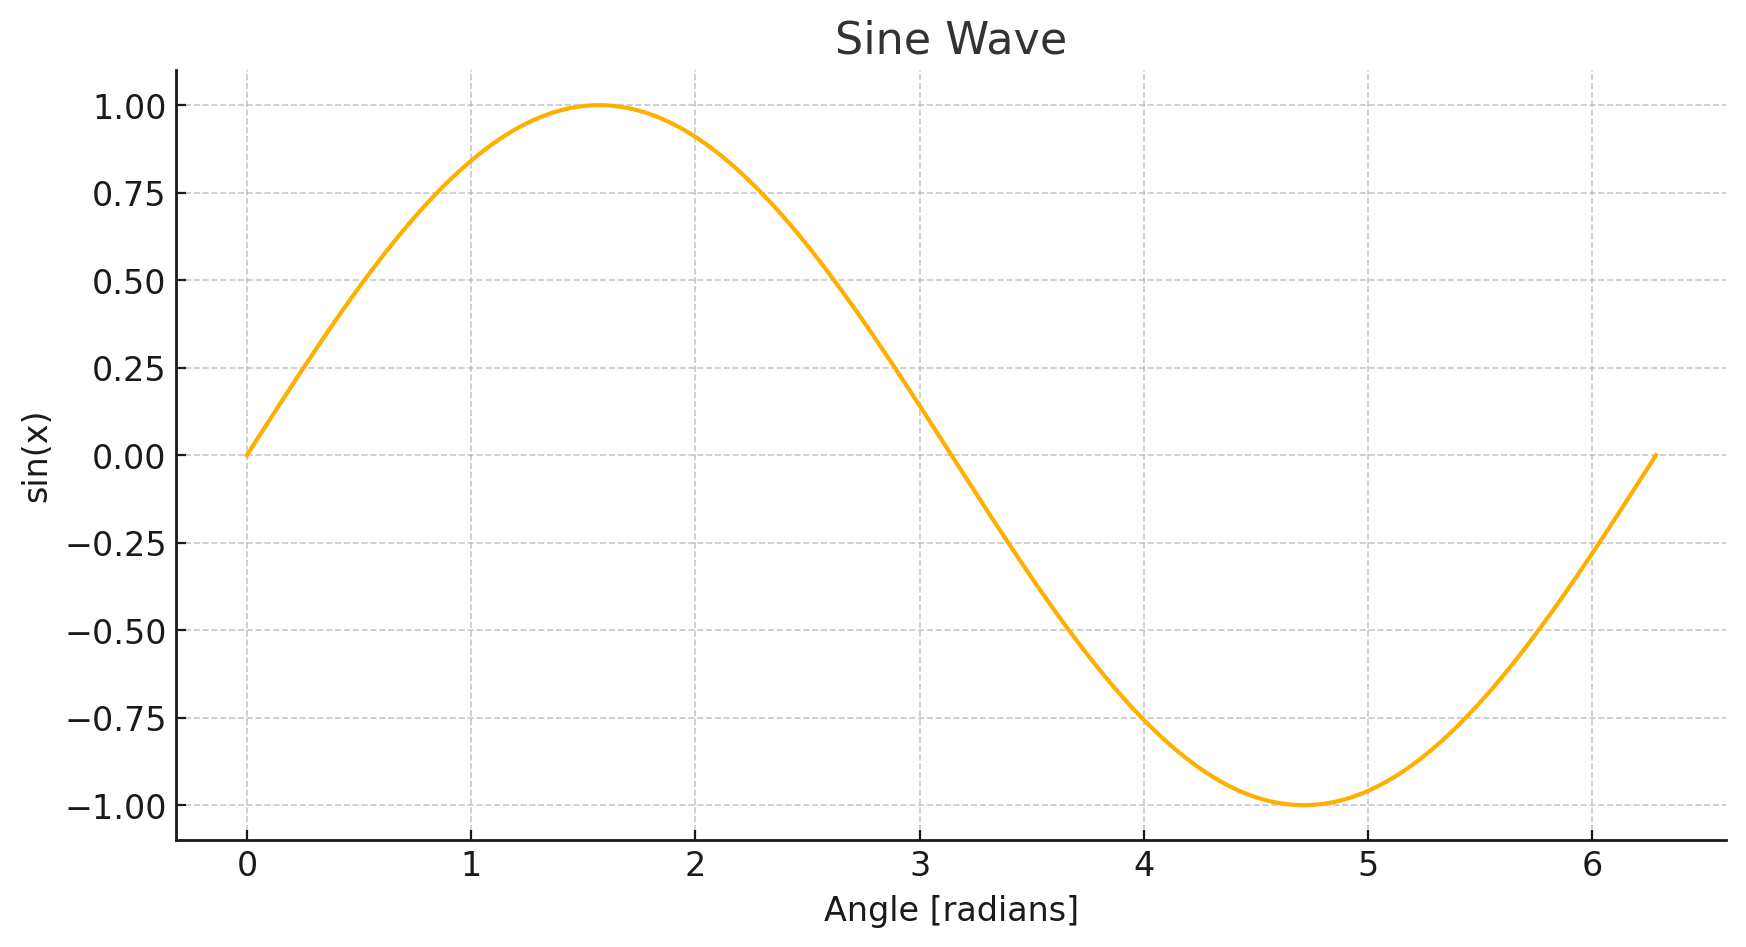

In [8]:
# Use the file id to retrieve the file content and save it on disk

from IPython.display import Image, display

content = client.files.content(file_id=file_id)
image= content.write_to_file(f"{file_id}.png")

# Display the image in the default image viewer
display(Image(filename=f"{file_id}.png")) 

# Add a new user question to the thread message list

In [9]:
client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="Show me the code you used to generate the sinewave"
)

messages = client.beta.threads.messages.list(thread_id=thread.id)

In [10]:
for m in messages:
    print(m.content, '\n')

[TextContentBlock(text=Text(annotations=[], value='Show me the code you used to generate the sinewave'), type='text')] 

[ImageFileContentBlock(image_file=ImageFile(file_id='assistant-2N35JHzk1dysz9kI03cN5wgg', detail=None), type='image_file'), TextContentBlock(text=Text(annotations=[], value='Here is a visualization of a sine wave, plotted over the interval from 0 to \\(2\\pi\\) radians. The x-axis represents the angle in radians, while the y-axis represents the value of the sine function at each angle.'), type='text')] 

[TextContentBlock(text=Text(annotations=[], value='Create a visualization of a sinewave'), type='text')] 



# Print the result of the second question

In [11]:
import time, json

run            = client.beta.threads.runs.create(
  thread_id    = thread.id,
  assistant_id = assistant.id,
  #instructions="New instructions" #You can optionally provide new instructions but these will override the default instructions
)

while client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id).status in ["queued", "in_progress"]:
    print(f"Run status: {run.status}")
    time.sleep(5)

print(f"Final run status: {client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id).status}")

Run status: queued
Final run status: completed


In [12]:
print(client.beta.threads.messages.list(thread_id=thread.id).data[0].content[0].text.value)

Here is the code used to generate and plot the sine wave:

```python
import numpy as np
import matplotlib.pyplot as plt

# Generate x values
x = np.linspace(0, 2 * np.pi, 1000)
# Compute sine of x
y = np.sin(x)

# Plot the sine wave
plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.title("Sine Wave")
plt.xlabel("Angle [radians]")
plt.ylabel("sin(x)")
plt.grid(True)
plt.show()
```

This code uses the `numpy` library to generate values between 0 and \(2\pi\), computes the sine for each of these values, and uses `matplotlib` to plot the resulting sine wave.


# New question: now we want the picture using dark mode
## Now we run everything in a single cell

Run status: queued
Final run status: completed
image_file: assistant-9vVRKnz3hlhNf05bVqYWDhXI
text: Here is the sine wave visualization in dark mode. The background has been changed to dark, and the sine wave is displayed in cyan to ensure good contrast. The labels and grid have also been adjusted to fit the dark theme.


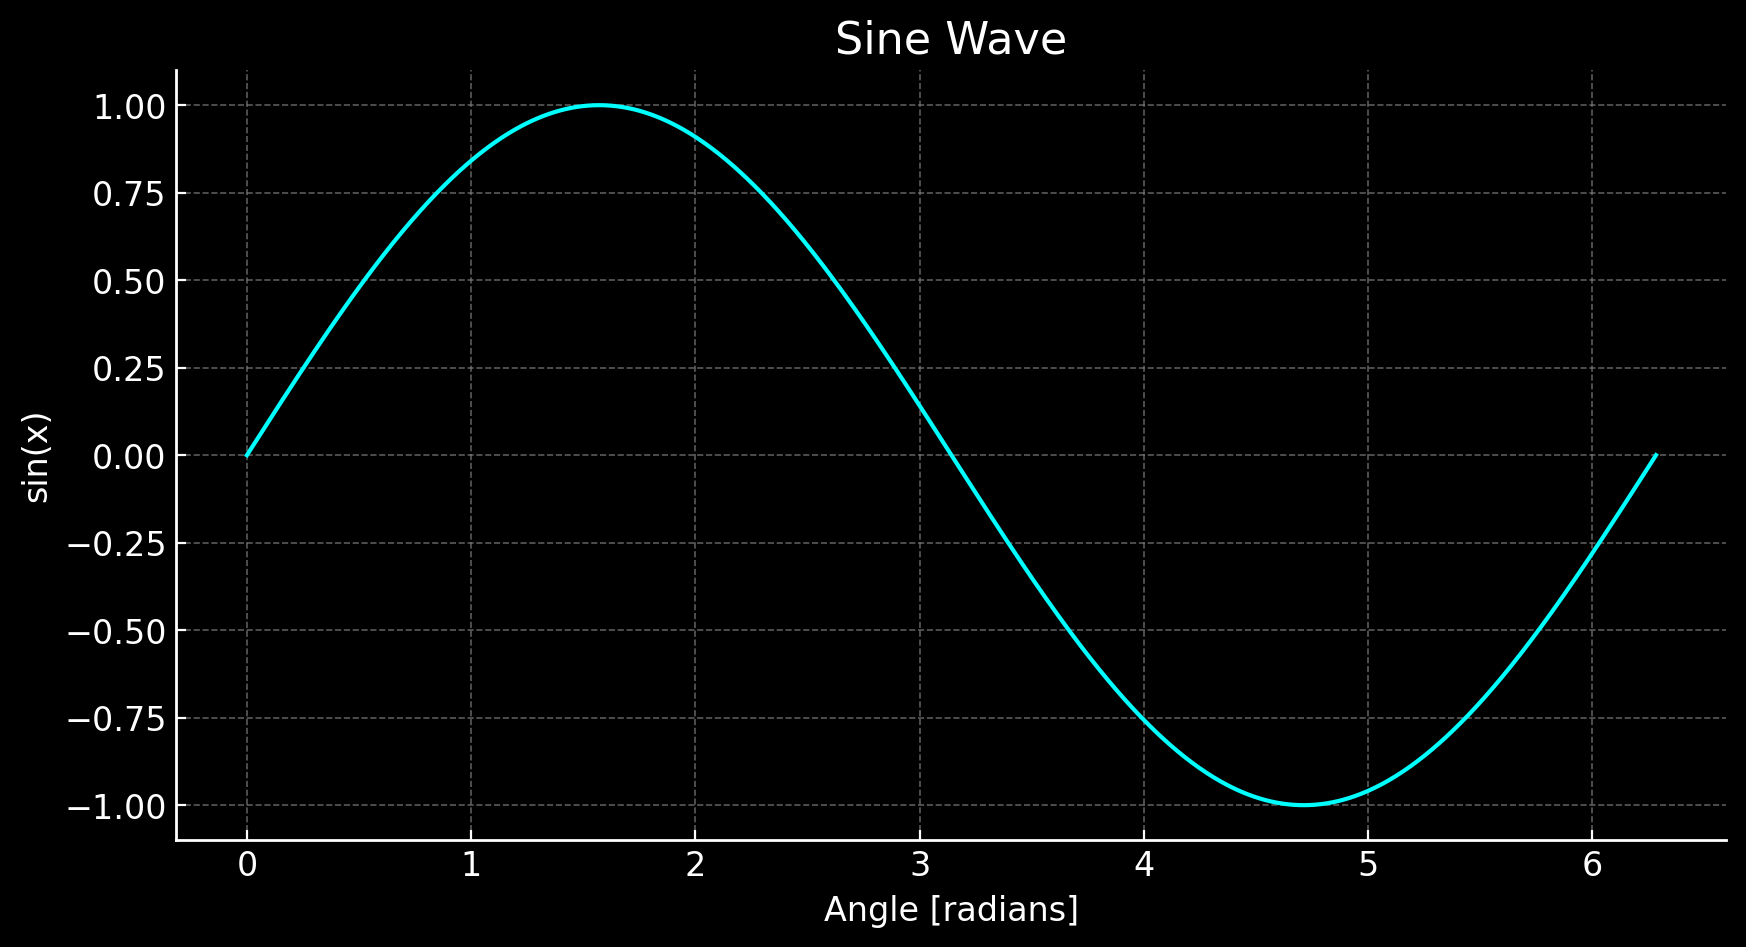

In [13]:
# Add a user question to the thread
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="I prefer visualizations in darkmode can you change the colors to make a darkmode version of this visualization."
)

run            = client.beta.threads.runs.create(
  thread_id    = thread.id,
  assistant_id = assistant.id,
  #instructions="New instructions" #You can optionally provide new instructions but these will override the default instructions
)

# Invoke the LLM passing the thread messages list
while client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id).status in ["queued", "in_progress"]:
    print(f"Run status: {run.status}")
    time.sleep(5)

print(f"Final run status: {client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id).status}")
 
messages = client.beta.threads.messages.list(thread_id=thread.id)

file_id = ""

for c in json.loads(messages.to_json())["data"][0]["content"]:
    if c["type"]=="text":
        print(f'text: {c["text"]["value"]}')
    elif c["type"]=="image_file":
        file_id = c["image_file"]["file_id"]
        print(f'image_file: {file_id}')

content = client.files.content(file_id=file_id)
image= content.write_to_file(f"{file_id}.png")

# Display the image in the default image viewer
display(Image(filename=f"{file_id}.png")) 